In [63]:
from ipytables import *

In [64]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5


In [65]:
import itertools
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd
pd.options.display.max_rows=20
pd.options.display.max_seq_items = 100
pd.options.display.max_colwidth = 100

In [66]:
#os.chdir("prepared_corpora/opinosis/")

In [141]:
def load_pf_group_index():
    df = pd.read_csv("./phrase_groups.csv")
    df.set_index(["paraphrase_group_index", "phrase_index"], inplace=True)
    return df
    

In [142]:
df = load_pf_group_index()
df["tokenized_phrases"]=[line.strip() for line in open("tokenized_phrases.txt","r")]


In [143]:
df["pvdm"]=list(np.loadtxt("outVectors_wiki_sentence_concat_pvdm.csv", delimiter=","))
df["dbow"]=list(np.loadtxt("outVectors_wiki_sentence_dbow.csv", delimiter=","))
df["urae"]=list(np.loadtxt("outVectors_RAE2011.csv", delimiter=","))
df["bow"]=list(np.loadtxt("outVectors_bow.csv", delimiter=","))


In [144]:
from sklearn.decomposition import PCA
df["pca_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.bow))))

In [145]:
#Just consider paraphrase groups of a certain size
df = df.groupby(level=0).filter(lambda group: len(group)>4)

In [146]:
#Dervived combined models
#ensembles = list(itertools.combinations(df.columns[1:],2))
#for ensemble in ensembles:
#    df["_".join(ensemble)] = df[ensemble[0]].combine(df[ensemble[1]], func=lambda a,b: np.concatenate((a,b)))


In [147]:
df

tokenized_phrases  \
paraphrase_group_index phrase_index                                                                                                        
1                      2             speaking of which , the keyboard 's relatively large size , at 92 % of the size of a normal one ...   
                       3                                            the keyboard , more than 90 % standard size , is just large enough .   
                       4                                            the keyboard is large enough to accommodate touch typing with ease .   
                       5                                                 speaking of typing , the keyboard is great , almost full size .   
                       6                                                it 's 90 % size keyboard does n't take too long to get used to .   
                       7                          the keyboard is only slightly smaller than a regular one , so it 's very comfortable .   
                       8                                    the keyboard is nearly full size and very comfortable to type on for hours .   
14                     42            the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...   
                       43            we were also told of the free wine reception at 5pm , great idea as it meant you could chat to y...   
                       44            the free happy hour really made the visit extra special , we met so many wonderful people during...   
...                                                                                                                                  ...   
141                    606                                                                    excellent location near fishermans wharf .   
                       607                                                                        perfect location to fishermans wharf .   
143                    610                           the location is mere walking distance to the wharf , cable car , and so much more .   
                       611           location is fantastic , 2 , 1 2 blocks from fisherman 's wharf , 4 blocks to pier 39 , 1 , 1 2 b...   
                       612           the hotel is in a fantastic location just a 5 minute walk from fisherman 's wharf and no more th...   
                       613           it is in a great location , 5 minute walk to fisherman 's wharf promenade and 5 minute walk to a...   
                       614                                        the location is excellent for access to the cable cars and the wharf .   
                       615                                excellent location 2 blocks from fishermans wharf and 1 block from cable car .   
                       616           the location is perfect , two blocks from fisherman 's wharf and only a block to the street car ...   
                       617                             the hotel is in a great location , close to fishermans wharf , cable cars , ect .   

                                                                                                                                    pvdm  \
paraphrase_group_index phrase_index                                                                                                        
1                      2             [-0.117434248328, -0.015163497068, -0.0158847086132, 0.0758114904165, -0.00432644132525, 0.03714...   
                       3             [-0.00158204487525, 0.0420459918678, 0.00303942873143, 0.0266706366092, -0.00238277693279, -0.02...   
                       4             [0.0286828167737, 0.0231479890645, 0.0258000101894, -0.00616379966959, -0.0199173390865, -0.0397...   
                       5             [-0.0913886651397, 0.0399422906339, 0.0419003777206, -0.00510333757848, -0.00751925306395, 0.002...   
                       6             [-0.0729923397303, -0

In [148]:
from matplotlib import colors as mpl_colors
import matplotlib.cm as cm

from collections import Counter
import random



lbls = df.index.get_level_values(0)
color_names = cm.Dark2 (np.linspace(0.0, 1, len(np.unique(lbls))))
color_dict = dict(zip(np.unique(lbls), color_names))
colors = [color_dict[lbl] for lbl in lbls]


names = df.tokenized_phrases.groupby(level=0).first()
Table(*[TableRow(TableCell(name,bg_colour=rgba_to_string(color_dict[id]))) for id, name in list(names.to_dict().items())])



"speaking of which , the keyboard 's relatively large size , at 92 % of the size of a normal one , writing longer texts on it is no problem ."
what a great hotel terrific location !
"hotel could not have been in a better location , ca n't be beat !"
great sound and very easy to use .
the location could n't be better in my opinion .
"the location ca n't be beat , a two , minute walk from the gloucester road tube stop ."
rooms very spacious and clean .
"the rooms were clean and well , cared for ."
the location was good if you want to be near fisherman 's wharf .
"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to socialise witheach other ."
rooms were a bit small but very clean and nicely maintained .


In [149]:
from sklearn.manifold import t_sne
def plot_tsne(column):
    tsne = t_sne.TSNE()
    Ys = tsne.fit_transform(np.row_stack(df[column]))
    
    pl.scatter(Ys[:,0],Ys[:,1], c=colors)
    pl.title = column
    
    

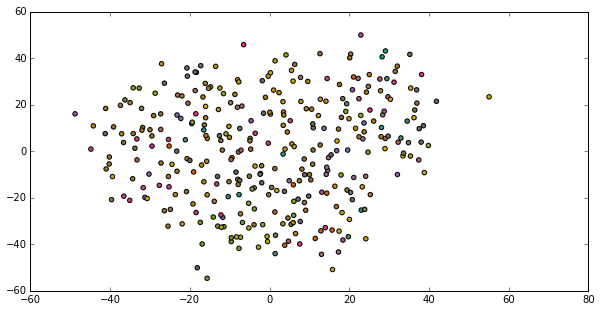

In [150]:
plot_tsne("urae")

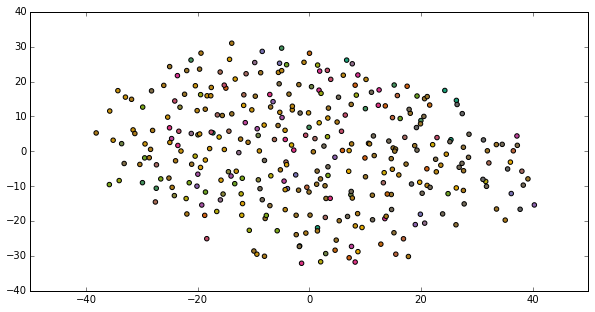

In [151]:
plot_tsne("pvdm")

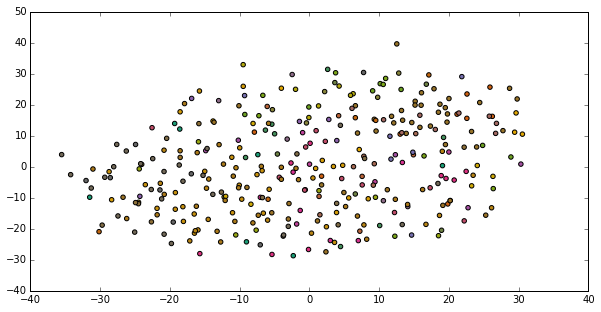

In [152]:
plot_tsne("dbow")

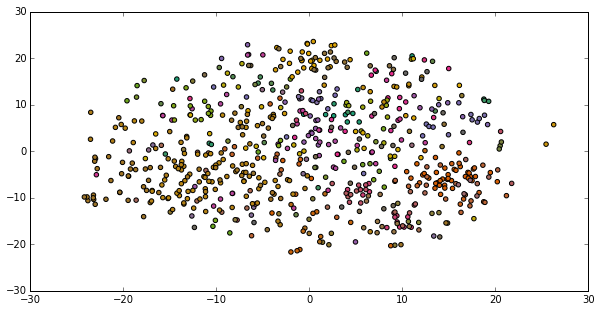

In [79]:
plot_tsne("bow")

#Wei's method


1. within each paraphrase group, for each model, work out average pair-wise cosine similarity (or distance)
2. treat each model's average similarity/distance for the paraphrase groups as a time series, do a z-normalisation () the time (horizontal) axis is the paraphrase group index, and the y axis is the similarity value after the z-normalisation
3. measure the similarity between the four model time series, pair-wise using Euclidean distance to see which model agrees with each other. 
4. the ground truth in this case should be horizontal x axis, which means the best values that each model gets should be close to zero (if you use similarity, rather than distance). So the model with an overall trend of low similarity values capture the semantics better.

In [80]:
import scipy.spatial.distance as distance

def angular_dist(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return np.arccos(cos_sim)*(2/np.pi)


,pvdm,dbow,urae,bow,pca_bow
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.160281,0.245958,0.268080,0.285696,0.200416
std,0.151984,0.048895,0.150432,0.086264,0.089415
min,-0.064408,0.147297,0.125454,0.172334,0.096640
25%,0.038857,0.222998,0.179060,0.221287,0.134659
50%,0.106155,0.250049,0.214013,0.279806,0.179397
75%,0.284535,0.285708,0.301429,0.343713,0.247843
max,0.469446,0.357150,0.827089,0.510187,0.427396


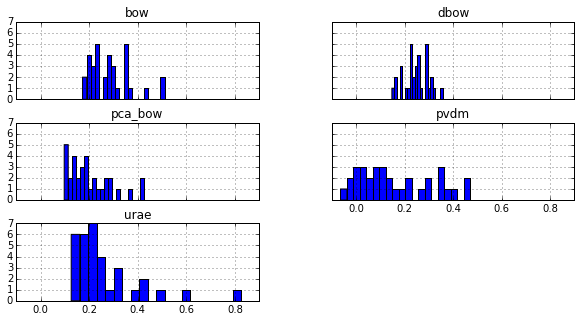

In [155]:
def get_group_sim(group):
    xs = np.row_stack(group)
    #cosine_sim = (1-distance.pdist(xs, 'cosine'))
    sim = 1-distance.pdist(xs,angular_dist)
    return sim.mean()

group_sims = df.groupby(level=0).agg(get_group_sim)
group_sims.hist(bins=20, sharex=True, sharey=True)
group_sims.describe()

In [82]:
def z_norm(col):
    return (col-col.mean())/col.std()

n_group_sims = group_sims.apply(z_norm)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa65e07fa20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa65dc0fac8>]], dtype=object)

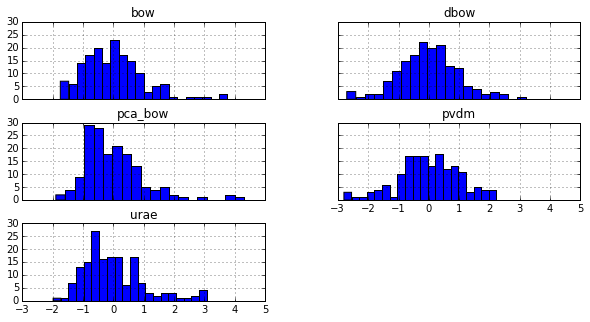

In [83]:
n_group_sims.hist(bins=20, sharex=True, sharey=True)

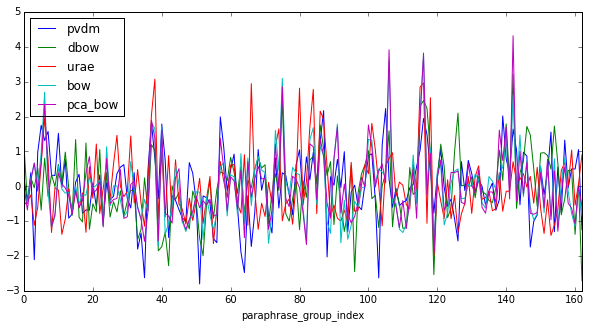

In [84]:
n_group_sims.plot()

              pvdm       dbow       urae        bow    pca_bow
pvdm      0.000000  14.601612  15.705667  13.874729  13.473015
dbow     14.601612   0.000000  16.638492  11.813499  11.583527
urae     15.705667  16.638492   0.000000  13.210895  13.669223
bow      13.874729  11.813499  13.210895   0.000000   4.698825
pca_bow  13.473015  11.583527  13.669223   4.698825   0.000000


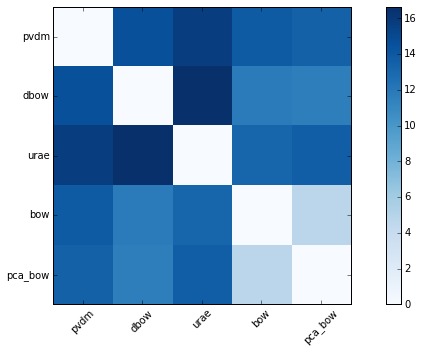

In [85]:
import matplotlib.cm as cm
def plot_matrix(cm, labels, cmap=cm.Blues):
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.colorbar()
    tick_marks = np.arange(len(labels))
    pl.xticks(tick_marks, labels, rotation=45)
    pl.yticks(tick_marks, labels)
    pl.tight_layout()
    
def get_interrater_e_distance(ratings):
    rating_dist = distance.pdist(n_group_sims.as_matrix().T)
    return distance.squareform(rating_dist)

interrater_e_distance = get_interrater_e_distance(n_group_sims)
print(pd.DataFrame( interrater_e_distance, columns =n_group_sims.columns, index=n_group_sims.columns))
      
plot_matrix(interrater_e_distance, n_group_sims.columns)

In [86]:
def get_centroid(group):
    xs = np.row_stack(group)
    return list(xs.mean(axis=0)) #Euclidean



def get_medoid(group):
    points=np.row_stack(group)
    ingroup_index = distance.cdist(points,points, 'cosine').sum(axis=1).argmin()
    return list(points[ingroup_index,:])


def get_angular_centroid(group):
    # the angular centroid is a line, here we choes an arbitairy point on it.
    # Dicussion of how normalising and adding wroks is at http://math.stackexchange.com/a/925659/1505
    points = np.row_stack(group)
    unit_points = points/np.linalg.norm(points,axis=1)[:,None]  #Normalise ot unit vectors
    return list(np.sum(unit_points,axis=0))
    

def get_group_medoids(series):
    return series.groupby(level=0).agg(get_medoid)


def get_group_centroids(series):
    return series.groupby(level=0).agg(get_centroid)


In [87]:

#Davies-Bouldin Index 
#Modified to use angular centroid, and angular distance

def davied_bouldin_index(series):

    def av_dist_to_centroid(group):
        xs = np.row_stack(group)
        c = get_angular_centroid(group)
        return distance.cdist(xs,[c], angular_dist).mean()

    group_centroids = get_group_centroids(series)
    group_spreads = series.groupby(level=0).agg(av_dist_to_centroid)
    
    n_groups = len(group_spreads)
    
    total = 0.0
    for ii in range(n_groups):
        greatest = -1*np.Inf
        for jj in range(n_groups):
            if ii==jj:
                continue

            numer = group_spreads.iloc[ii] + group_spreads.iloc[jj] 
            denom = angular_dist(group_centroids.iloc[ii],group_centroids.iloc[jj]) #Euclidean
            value = numer/denom
            greatest = max(greatest, value)
        total+= greatest
    return total/n_groups

            
for column in df.columns[1:]:
    print(column + " " + str(davied_bouldin_index(df.loc[:,column])))

pvdm 2.88931421942
dbow 1.87993380932
urae 2.37436804913
bow 1.62906158416
pca_bow 1.4746116557


In [ ]:
def get_true_classes(series):
    return np.asarray([ii[0] for ii in series.index])

In [164]:
df.bow.groupby(level=0).agg(len).idxmax()

24

In [167]:
len(df.bow[4])

0

In [169]:
def get_classes_about_center(series, center_fun):
    group_centers = np.row_stack(series.groupby(level=0).agg(center_fun)) 
    points  = np.row_stack(series)
    class_indexes = distance.cdist(points,group_centers, 'cosine').argmin(axis=1)
    return np.asarray(series.index[class_indexes].labels[0])

def get_classes_by_similarity_to_true_classes(series):
    true_classes = get_true_classes(series)
    
    def av_dist_to_group(point, group):
        xs = np.row_stack(group)
        return distance.cdist(xs, [point]).mean()
    
    return np.asarray([series.groupby(level=0).agg(lambda group: av_dist_to_group(point, group)).idxmin()
               for point in series])
    



def recluster_success(series):
    true_classes = get_true_classes(series)

    def get_acc(center_fun):
        classes = get_classes_about_center(series, center_fun)
        return (classes == true_classes).sum()/len(true_classes)
    
    classes = get_classes_by_similarity_to_true_classes(series)
    group_closeness_acc = (classes == true_classes).sum()/len(true_classes)

    return pd.Series([get_acc(get_centroid),
                      get_acc(get_medoid),
                      get_acc(get_angular_centroid),
                      group_closeness_acc
                     ], index="centroid_acc medoid_acc angular_centroid_acc group_closeness_acc".split()) 
    

recluster_results = pd.DataFrame()
for column in df.columns[1:]:
    recluster_results[column] = recluster_success(df[column])

recluster_results

,pvdm,dbow,urae,bow,pca_bow
centroid_acc,0.039039,0.021021,0.018018,0.021021,0.021021
medoid_acc,0.042042,0.021021,0.054054,0.012012,0.018018
angular_centroid_acc,0.048048,0.021021,0.018018,0.021021,0.021021
group_closeness_acc,0.276276,0.762763,0.438438,0.801802,0.777778


In [181]:
#Lets take a look at what mistakes are being made.
#We can look at the exemplary member of each class as a repressentitive,
#And can compare that for the class it was given to that for the class it should have been given

def get_exemplars(df, col_name, get_center_fun):
    series = df[col_name]
    def get_exemplar(group):
        c = get_center_fun(group)
        points=np.row_stack(group)
        ingroup_index = distance.cdist(points,[c], 'cosine').flatten().argmin()
        df_index = group.index[ingroup_index]
        return df.tokenized_phrases[df_index]
    
    return series.groupby(level=0).agg(get_exemplar)


def get_mistakes(df, col_name, get_center_fun=get_angular_centroid):
    group_exemplars = get_exemplars(df, col_name,get_center_fun)
    
    series = df[col_name]
    
    classes = get_classes(series, get_center_fun)
    
    return show_mistakes(df, classes, col_name, get_center_fun)


def show_mistakes(df, actual_classes, col_for_exemplar="bow", get_center_fun = get_angular_centroid):
    group_exemplars = get_exemplars(df, col_for_exemplar, get_center_fun)
    
    true_classes = get_true_classes(df)
    mistake_indexs = np.nonzero(actual_classes!=true_classes)
    
    ret = pd.DataFrame()
    ret["mistaken_texts"] = list(df.tokenized_phrases.iloc[mistake_indexs])
    ret["true_exemplar"] = list(group_exemplars[true_classes[mistake_indexs]])
    ret["actual_exemplar"] = list(group_exemplars[actual_classes[mistake_indexs]])
    
    return ret


In [182]:
show_mistakes(df, get_classes_by_similarity_to_true_classes(df.bow))

,mistaken_texts,true_exemplar,actual_exemplar
0,the keyboard is large enough to accommodate touch typing with ease .,"speaking of typing , the keyboard is great , almost full size .",the transmission is not the smoothest .
1,the keyboard is nearly full size and very comfortable to type on for hours .,"speaking of typing , the keyboard is great , almost full size .",the rooms were spacious and clean .
2,"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","the room was clean , neat and very well kept ."
3,"we were also told of the free wine reception at 5pm , great idea as it meant you could chat to y...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","the rooms were very nice , clean and comfortable ."
4,"the free happy hour really made the visit extra special , we met so many wonderful people during...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...",the transmission is not the smoothest .
5,the nightly free wine reception is a great way to meet people and find out what is worth seeing ...,"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...",the transmission is not the smoothest .
6,"the free beer , wine etc and snacks on an afternoon was a lovely touch and helped you swap tips ...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","the room was clean , neat and very well kept ."
7,"the lobby has a wine tasting for free between 5 , 6pm each night and you meet dozens of really n...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","the rooms were very nice , clean and comfortable ."
8,staff and concierge were very helpful .,the staff were very helpful .,the staff was very friendly and helpful .
9,the customer service was wonderful .,the staff were very helpful .,the service truly was above and beyond .


In [177]:
get_mistakes(df, "bow",get_angular_centroid)

,mistaken_texts,true_exemplar,actual_exemplar
0,"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
1,"we were also told of the free wine reception at 5pm , great idea as it meant you could chat to y...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
2,"the free happy hour really made the visit extra special , we met so many wonderful people during...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
3,the nightly free wine reception is a great way to meet people and find out what is worth seeing ...,"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
4,they have a happy hour where you have a couple offree drinks between 5 and 6 and this gives you ...,"the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
5,"the free beer , wine etc and snacks on an afternoon was a lovely touch and helped you swap tips ...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
6,"the lobby has a wine tasting for free between 5 , 6pm each night and you meet dozens of really n...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
7,"evening wine hour from 5 , 6 was also good , free wine and nibbles and a chance to talk to other...","the nightly free wine tasting from 5 , 6 pm is a brilliant idea and gets guests together to soci...","speaking of typing , the keyboard is great , almost full size ."
8,the hotel offers free wifi to all guests who have a laptop .,the hotel has free wireless .,"speaking of typing , the keyboard is great , almost full size ."
9,i personally appreciated the free internet service in the hotel .,the hotel has free wireless .,"speaking of typing , the keyboard is great , almost full size ."


In [93]:
get_mistakes(df, "dbow",get_angular_centroid)

,mistaken_texts,expected_exemplar,actual_exemplar
0,"speaking of which , the keyboard 's relatively large size , at 92 % of the size of a normal one ...","the keyboard , more than 90 % standard size , is just large enough .",keyboard is actually a pleasure to use inspite of small size
1,"the keyboard , more than 90 % standard size , is just large enough .","the keyboard , more than 90 % standard size , is just large enough .",keyboard is actually a pleasure to use inspite of small size
2,the keyboard is large enough to accommodate touch typing with ease .,"the keyboard , more than 90 % standard size , is just large enough .",keyboard is actually a pleasure to use inspite of small size
3,"speaking of typing , the keyboard is great , almost full size .","the keyboard , more than 90 % standard size , is just large enough .",keyboard is actually a pleasure to use inspite of small size
4,it 's 90 % size keyboard does n't take too long to get used to .,"the keyboard , more than 90 % standard size , is just large enough .",no free internet here though .
5,"the keyboard is only slightly smaller than a regular one , so it 's very comfortable .","the keyboard , more than 90 % standard size , is just large enough .",keyboard is actually a pleasure to use inspite of small size
6,the keyboard is nearly full size and very comfortable to type on for hours .,"the keyboard , more than 90 % standard size , is just large enough .",the front desk staff was professional and very helpful .
7,"the keyboard is functional , but takes a little bit of getting use to .","keyboard feels funny at first , but you get used to it .","the keyboard , more than 90 % standard size , is just large enough ."
8,the keyboard takes a bit of getting used to .,"keyboard feels funny at first , but you get used to it .","the keyboard , more than 90 % standard size , is just large enough ."
9,"keyboard feels funny at first , but you get used to it .","keyboard feels funny at first , but you get used to it .","the keyboard , more than 90 % standard size , is just large enough ."


In [94]:
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}

def classify(column, classifier, train_data, test_data, train_labels, test_labels):
    train_data_X = np.row_stack(train_data[column])
    test_data_X = np.row_stack(test_data[column])

    classifier.fit(train_data_X, train_labels)
    
    return classifier.score(test_data_X, test_labels)


classifiers = [LinearSVC(class_weight="auto",  max_iter=200), 
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10),
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100),        
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000),
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10000),
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100000),
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000000),
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10000000),
       SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100000000),
        #OneVsRestClassifier(SVC(class_weight="auto",  max_iter=20000, kernel='rbf')),
        #tree.DecisionTreeClassifier(class_weight="auto")
        
        
       ]
best_classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    best_classify_results.loc[:,column] = [classify(column, classifier,
                                                   train_data=df,
                                                   test_data=df,
                                                   train_labels=get_true_classes(df),
                                                   test_labels=get_true_classes(df))
                                            for classifier in classifiers]
    
best_classify_results

,pvdm,dbow,urae,bow,pca_bow
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=200,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.439462,0.962631,0.772795,1.000000,0.998505
"SVC(C=10, cache_size=200, class_weight='auto', coef0=0.0, degree=3, gamma=0.0,\n kernel='rbf', max_iter=20000, probability=False, random_state=None,\n shrinking=True, tol=0.001, verbose=False)",0.077728,0.091181,0.089686,0.158445,0.557549
"SVC(C=100, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.025411,0.859492,0.521674,0.935725,0.977578
"SVC(C=1000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.153961,0.991031,0.916293,0.997010,0.998505
"SVC(C=10000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.678625,1.000000,0.997010,1.000000,1.000000
"SVC(C=100000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.971599,1.000000,1.000000,1.000000,1.000000
"SVC(C=1000000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.998505,1.000000,1.000000,1.000000,1.000000
"SVC(C=10000000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",1.000000,1.000000,1.000000,1.000000,1.000000
"SVC(C=100000000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
from sklearn import cross_validation
n_folds = df.tokenized_phrases.groupby(level=0).agg(len).min()
print(str(n_folds)+"-fold validation")
classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    for classifier in classifiers:
        cv_res = cross_validation.cross_val_score(classifier, 
                                          X = np.row_stack(df[column]),
                                          y = get_true_classes(df),
                                          cv=df[column].groupby(level=0).agg(len).min(),
                                          n_jobs=-1
                                        
                                          )
        classify_results.loc[classifier,(column)] = cv_res.mean()
        #classify_results.loc[svm,(column+"_std")] = cv_res.std()

classify_results

2-fold validation


,pvdm,dbow,urae,bow,pca_bow
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=200,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.078889,0.218900,0.094214,0.514871,0.477385
"SVC(C=10, cache_size=200, class_weight='auto', coef0=0.0, degree=3, gamma=0.0,\n kernel='rbf', max_iter=20000, probability=False, random_state=None,\n shrinking=True, tol=0.001, verbose=False)",0.022682,0.075777,0.029176,0.098504,0.119370
"SVC(C=100, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.029608,0.172672,0.053243,0.311014,0.457235
"SVC(C=1000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.030084,0.248552,0.120098,0.457235,0.468792
"SVC(C=10000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.071964,0.252037,0.153191,0.457473,0.473662
"SVC(C=100000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.139966,0.252037,0.151806,0.457473,0.473662
"SVC(C=1000000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.142736,0.252037,0.151806,0.457473,0.473662
"SVC(C=10000000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.142736,0.252037,0.151806,0.457473,0.473662
"SVC(C=100000000, cache_size=200, class_weight='auto', coef0=0.0, degree=3,\n gamma=0.0, kernel='rbf', max_iter=20000, probability=False,\n random_state=None, shrinking=True, tol=0.001, verbose=False)",0.142736,0.252037,0.151806,0.457473,0.473662


In [153]:
def get_symetry_measure(group):
    xs = np.row_stack(group)
    dist=distance.pdist(xs, angular_dist)
    c=get_angular_centroid(xs)
    dist = distance.cdist(xs, [c],angular_dist)
    return dist.std()

df.groupby(level=0).agg(get_symetry_measure).describe()
    

,pvdm,dbow,urae,bow,pca_bow
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.193430,0.066737,0.119585,0.072637,0.087284
std,0.065886,0.022110,0.049855,0.024122,0.032090
min,0.063945,0.025113,0.028495,0.035556,0.029252
25%,0.160559,0.053953,0.081377,0.059257,0.064469
50%,0.187297,0.064911,0.125996,0.066266,0.080625
75%,0.239619,0.084599,0.154199,0.089317,0.107795
max,0.332394,0.107505,0.243192,0.120452,0.158473
